## Lunar lander TD-0 with linear regression

In [ ]:
import gym
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numba import njit

In [8]:
np.set_printoptions(linewidth=200)
%config InlineBackend.figure_format = "retina"
sns.set_palette("colorblind")

In [9]:
# env = gym.make("LunarLander-v2", render_mode="human")
env = gym.make("LunarLander-v2")
# env  = gym.make("MountainCar-v0")
observation, info = env.reset(seed=314)

## Single run

In [10]:
n_steps = 200
all_rewards = np.zeros(n_steps)
for t in range(n_steps):
    # action = env.action_space.sample()  # this is where you would insert your policy
    action = 0
    observation, reward, terminated, truncated, info = env.step(action)
    all_rewards[t] = reward
    print(action, end=" ")
    
    if terminated or truncated:
        observation, info = env.reset()
        break

print(f"\n{all_rewards.sum()}")
env.close()

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
-93.05003848484264


/Users/gerardoduran/mambaforge/envs/py310/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## The action-value function

$$
    q(s, a, {\bf w}) = {\bf w}_a^\intercal\phi(s)
$$

In [451]:
actions = np.arange(4)
n_actions = 4

In [538]:
def phi(s):
    return s
    sprime = np.concatenate([observation, observation ** 2])
    return sprime

def action_value(W, s, a):
    w = W[a]
    return w @ phi(s)

def grad_action_value(W, s, a):
    return phi(s)


def eval_action_value(W, s, actions):
    q_a = np.array([action_value(W, s, ai) for ai in actions])
    return q_a


def choose_max_action(action_value_est):
    vmax = action_value_est.max()
    if np.sum(vmax == action_value_est) == 1:
        return np.argmax(action_value_est)
    else:
        actions = np.arange(len(action_value_est))
        av_sub = actions[action_value_est == vmax]
        return np.random.choice(av_sub)


def eps_greedy_choice(W, s, eps):
    u = np.random.uniform()
    if u < eps:
        a = np.random.choice(4)
    else:
        action_value_estimates = eval_action_value(W, s, actions)
        a = choose_max_action(action_value_estimates)
    return a


def update_qweights(W, s, a, r, s_next, a_next, gamma, alpha):
    """
    Update weights using SARSA algorithm
    """
    W = np.copy(W)
    td_err = r + gamma * action_value(W, s_next, a_next) - action_value(W, s, a)
    w = W[a] + alpha * td_err * grad_action_value(W, s, a)
    W[a] = w
    return W

In [ ]:
n_steps = 500_000
eps = 1e-4
gamma = 0.999
# alpha = 0.001
alpha = 0.005

all_rewards = np.zeros(n_steps)
env = gym.make("LunarLander-v2")
observation, info = env.reset(seed=314)
action = eps_greedy_choice(W, observation, eps)
final_rewards = []


dim_phi = len(phi(observation))
np.random.seed(314)
W = np.random.randn(n_actions, dim_phi)
W = W.astype("float32")
# W = np.zeros((n_actions, dim_phi))


# observations = np.zeros((n_steps, 8))
episode_reward = 0.0
for t in tqdm(range(n_steps)):
    observation_next, reward, terminated, truncated, info = env.step(action)
    
    action_next = eps_greedy_choice(W, observation_next, eps)

    reset = terminated or truncated
    gamma_step = 0.0 if reset else gamma

    W = update_qweights(
        W, observation, action, reward, observation_next, action_next, gamma_step, alpha
    )
    
    if reset:
        final_rewards.append(episode_reward)
        observation, info = env.reset()
        action = eps_greedy_choice(W, observation, eps)
        episode_reward = 0.0
    else:
        episode_reward += reward
        observation = observation_next
        action = action_next


    all_rewards[t] = reward
    # observations[t] = observation

final_rewards = pd.Series(final_rewards)
print(f"\n{all_rewards.sum()}")
env.close()

  0%|                                                                                                                                                         | 0/500000 [00:00<?, ?it/s]/Users/gerardoduran/mambaforge/envs/py310/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
  3%|████▋                                                                                                                                      | 16915/500000 [00:09<06:18, 1275.69it/s]

In [545]:
final_rewards.ewm(span=100, min_periods=100).mean().tail()

948   -26.774023
949   -26.339111
950   -26.372565
951   -26.613715
952   -26.600527
dtype: float64

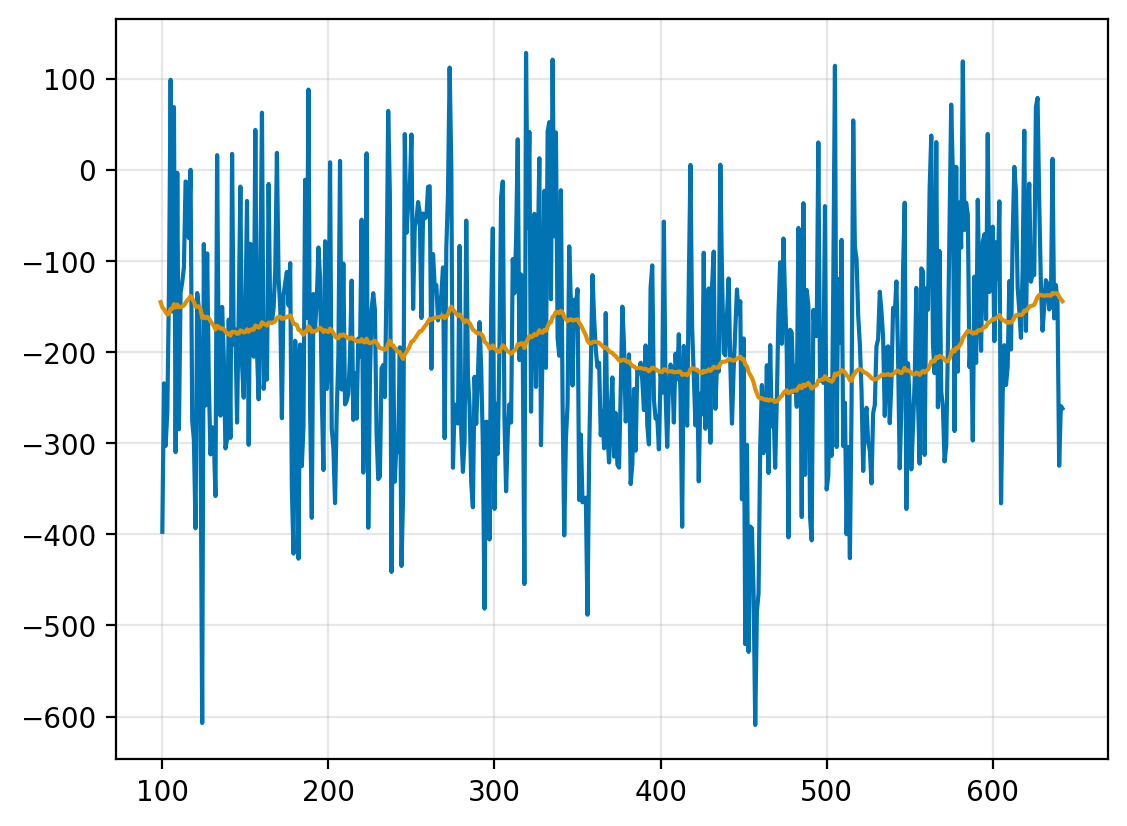

In [554]:
final_rewards.iloc[100:].plot()
final_rewards.ewm(span=100, min_periods=100).mean().plot()
plt.grid(alpha=0.3)

## Testing policy

In [472]:
np.save("weights", W)

In [474]:
Ws = np.load("weights.npy")

In [468]:
n_steps = 1000
eps = 1e-5

env = gym.make("LunarLander-v2")
observation, info = env.reset(seed=3141)
action = eps_greedy_choice(W, observation, eps)

observations = []
rewards = []
actions_hist = []

episode_reward = 0.0
for t in range(n_steps):
    observation, reward, terminated, truncated, info = env.step(action)
    
    action = eps_greedy_choice(W, observation, eps)

    reset = terminated or truncated
    rewards.append(reward)
    actions_hist.append(action)
    observations.append(observation)
    
    if reset:
        observation, info = env.reset()
        # action = eps_greedy_choice(W, observation, eps)
        break


observations = np.array(observations)
rewards = np.array(rewards)
print(f"\n{rewards.sum()}")
env.close()


-145.73630857793233


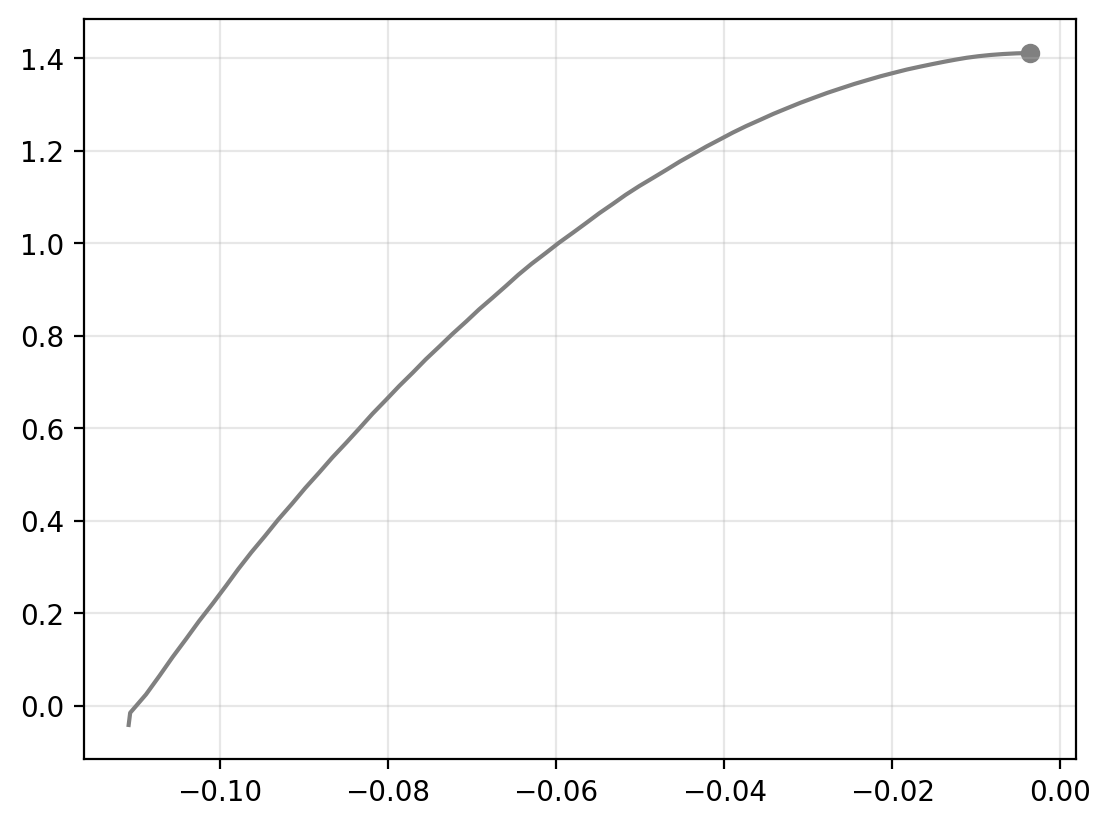

In [469]:
plt.plot(*observations[:, :2].T, c="gray")
plt.scatter(*observations[0, :2], c="gray")
plt.grid(alpha=0.3)

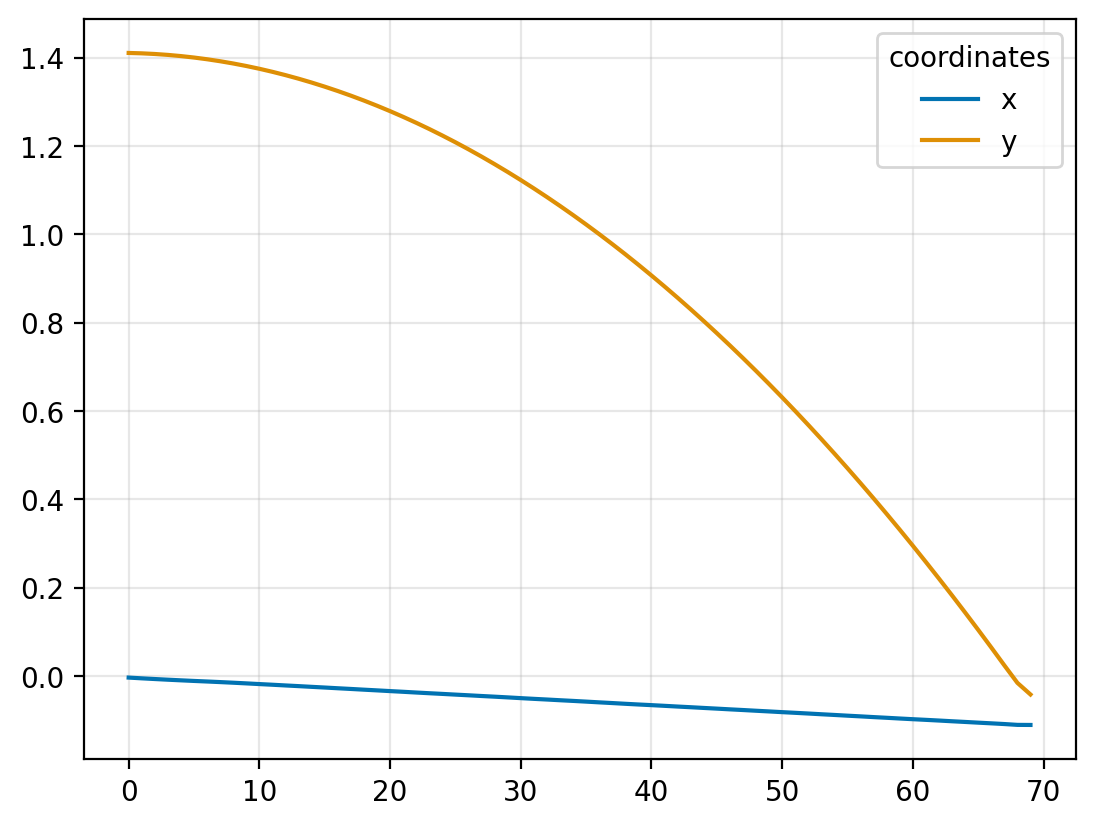

In [505]:
plt.plot(observations[:, :2], label=["x", "y"])
plt.legend(title="coordinates")
plt.grid(alpha=0.3)

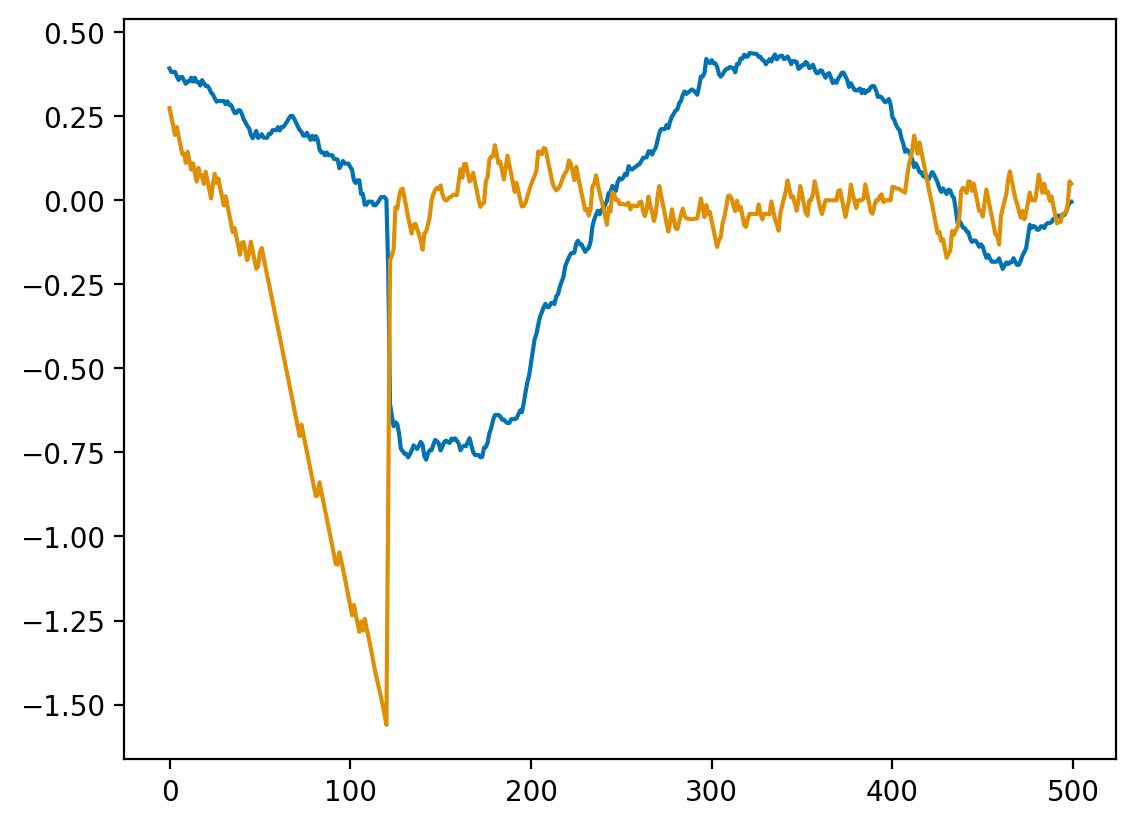

In [117]:
plt.plot(observations[:, 2:4])

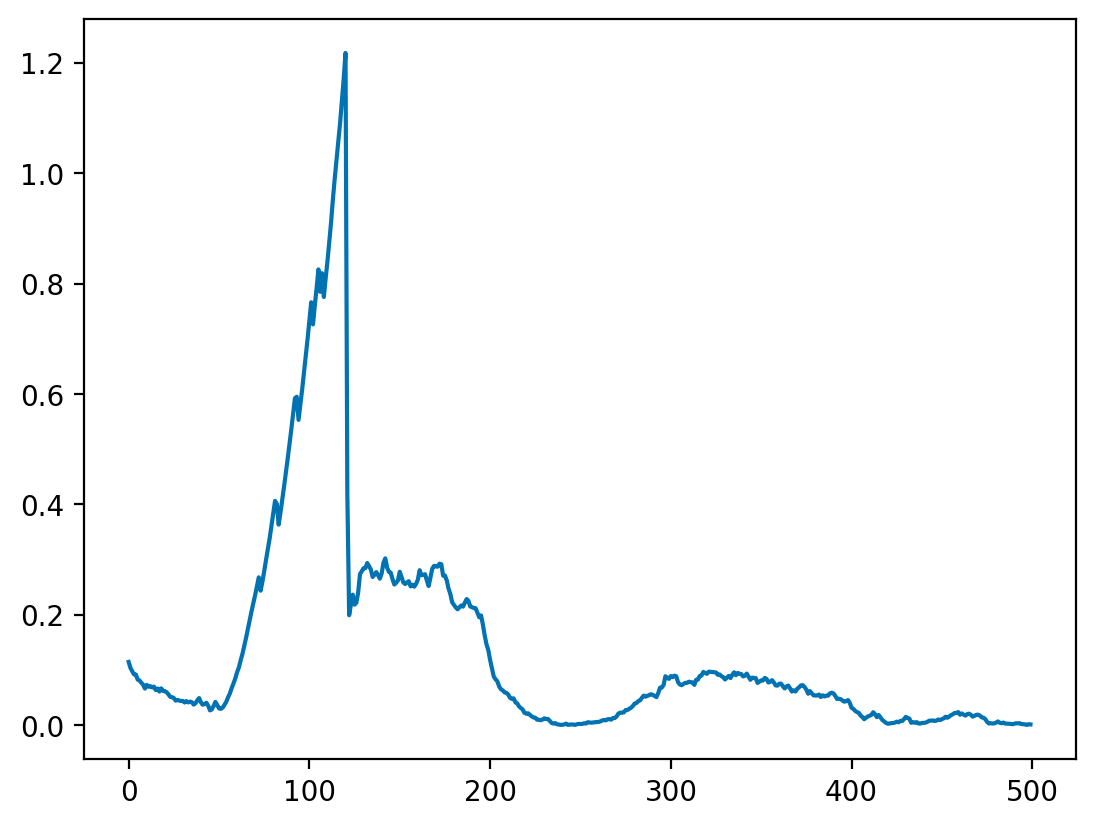

In [118]:
vel = np.power(observations[:, 2:4], 2).mean(axis=1)
plt.plot(vel)